In [1]:
import xarray as xr
from glob import glob
from datetime import datetime
import yaml
import os

import plotting

try:
    from ecco_pipeline.conf.global_settings import GRIDS, OUTPUT_DIR
    from ecco_pipeline.utils.file_utils import get_date
    import ecco_pipeline.transformations.transformation as Transformation
except:
    os.chdir(os.path.realpath(os.path.join(os.path.abspath(''), '../../..')))
    from ecco_pipeline.conf.global_settings import GRIDS, OUTPUT_DIR
    from ecco_pipeline.utils.file_utils import get_date
    import ecco_pipeline.transformations.transformation as Transformation

In [2]:
ds_name = "L3_DEBIAS_LOCEAN_v5_q09"
hemisphere = ''
with open(f'conf/ds_configs/{ds_name}.yaml', 'r') as stream:
    config = yaml.load(stream, yaml.Loader)

# Load sample granule

In [3]:
ds_granules_dir = f'{OUTPUT_DIR}/{ds_name}/harvested_granules/'
ds_granules = glob(f'{ds_granules_dir}/**/*.nc*')
if hemisphere:
    ds_granules = [g for g in ds_granules if hemisphere in g]
sample_granule_path = ds_granules[0]
print(sample_granule_path)

/Users/marlis/Developer/ECCO/ecco_output/L3_DEBIAS_LOCEAN_v5_q09/harvested_granules/2019/SMOS_L3_DEBIAS_LOCEAN_AD_20190101_EASE_09d_25km_v05.nc


In [4]:
filename_date_str = get_date(config['filename_date_regex'], sample_granule_path.split('/')[-1])
granule_date = datetime.strptime(filename_date_str, config['filename_date_fmt']).strftime('%Y-%m-%dT%H:%M:%SZ')
ds = xr.open_dataset(sample_granule_path)
ds

<xarray.Dataset>
Dimensions:     (lat: 584, lon: 1388, time: 1, bound: 2)
Coordinates:
  * lat         (lat) float32 -83.52 -81.98 -80.7 -79.57 ... 80.7 81.98 83.52
  * lon         (lon) float32 -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9
  * time        (time) datetime64[ns] 2019-01-01
Dimensions without coordinates: bound
Data variables:
    timebounds  (bound) datetime64[ns] ...
    SSS         (lat, lon) float32 ...
    eSSS        (lat, lon) float32 ...
Attributes:
    Conventions:    CF-1.6
    title:          SMOS SSS - LOCEAN_ACRI_v2020
    institution:    CEC-OS LOCEAN/IPSL/ACRI-ST
    source:         SMOS L2OS RE05 (CATDS, 3rd reprocessing RE05 + operationn...
    references:     http://catds.ifremer.fr/Products/Available-products-from-...
    history:        Processed on 2020-12-04 by $Id: prepare_data_CEC_CATDSfor...
    comment:        
    creation_time:  06-Dec-2020 16:15:04

# Load grid

In [5]:
grids = glob(f'grids/*.nc*')
grids.sort()
f'Available grids: {grids}'

"Available grids: ['grids/ECCO_llc270.nc', 'grids/ECCO_llc90.nc', 'grids/grid_tpose6_radius.nc', 'grids/polar_stereo_n_25km.nc']"

In [6]:
grid_ds = xr.open_dataset(grids[1])
grid_ds

<xarray.Dataset>
Dimensions:                (tile: 13, j: 90, i: 90)
Coordinates:
  * tile                   (tile) int16 0 1 2 3 4 5 6 7 8 9 10 11 12
  * j                      (j) int16 0 1 2 3 4 5 6 7 ... 82 83 84 85 86 87 88 89
  * i                      (i) int16 0 1 2 3 4 5 6 7 ... 82 83 84 85 86 87 88 89
Data variables:
    XC                     (tile, j, i) float32 ...
    YC                     (tile, j, i) float32 ...
    effective_grid_radius  (tile, j, i) float32 ...
Attributes:
    name:                  ECCO_llc90
    type:                  llc
    geospatial_lat_min:    -89.873055
    geospatial_lat_max:    89.739395
    geospatial_lon_min:    -179.98895
    geospatial_lon_max:    179.98691
    geospatial_lat_units:  degrees_north
    geospatial_lon_units:  degrees_east

In [7]:
T = Transformation.Transformation(config, sample_granule_path, granule_date)

# Make mapping factors

In [8]:
factors = T.make_factors(grid_ds)

/Users/marlis/opt/anaconda3/envs/ecco_pipeline/lib/python3.10/site-packages/pyproj/crs/crs.py:1286: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


Only using 100 nearest neighbours, but you may need up to 2933
0 %
5 %
10 %
15 %
21 %
26 %
31 %
36 %
42 %
47 %
52 %
57 %
63 %
68 %
73 %
78 %
84 %
89 %
94 %


# Transformation

In [9]:
field_ds_list = T.transform(grid_ds, factors, ds, config)

In [10]:
field_ds = field_ds_list[0][0]
field_ds

<xarray.Dataset>
Dimensions:                         (time: 1, tile: 13, j: 90, i: 90, nv: 2)
Coordinates:
  * time                            (time) datetime64[ns] 2019-01-01T12:00:00
  * tile                            (tile) int16 0 1 2 3 4 5 6 7 8 9 10 11 12
  * j                               (j) int16 0 1 2 3 4 5 ... 84 85 86 87 88 89
  * i                               (i) int16 0 1 2 3 4 5 ... 84 85 86 87 88 89
    XC                              (tile, j, i) float32 -111.6 ... -111.9
    YC                              (tile, j, i) float32 -88.24 -88.38 ... -88.1
    time_bnds                       (time, nv) datetime64[ns] 2019-01-01 2019...
Dimensions without coordinates: nv
Data variables:
    SSS_interpolated_to_ECCO_llc90  (time, tile, j, i) float64 9.969e+36 ... ...
Attributes:
    interpolated_grid:            ECCO_llc90
    model_grid_type:              llc
    original_dataset_title:       SMOS SSS L3 maps generated by CATDS CEC LOC...
    original_dataset_short_name:  L3_DEBIAS_LOCEAN_v5_q09
    original_dataset_url:         https://www.catds.fr/Products/Available-pro...
    original_dataset_reference:   https://www.seanoe.org/data/00417/52804/#79565
    original_dataset_doi:         10.17882/52804
    interpolated_grid_id:         ECCO_llc90
    transformation_version:       1.0
    notes:

# Visualization

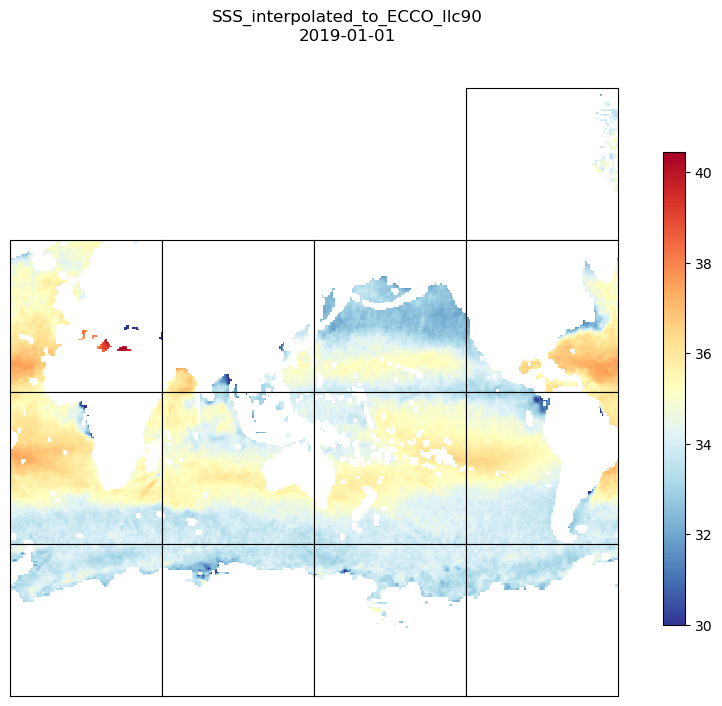

In [11]:
field_ds = field_ds_list[0]
plotting.make_plot(field_ds[0][list(field_ds[0].data_vars)[0]], vmin=30)


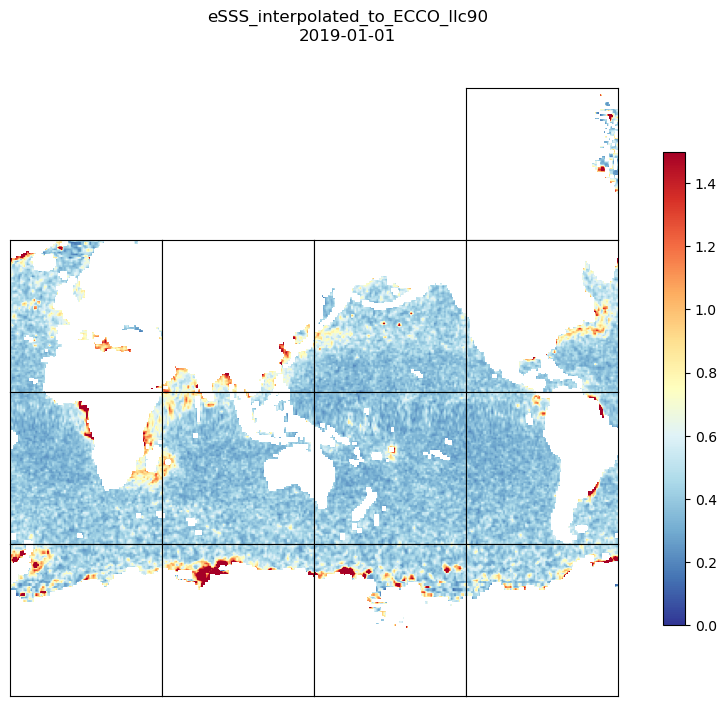

In [12]:
field_ds = field_ds_list[1]
plotting.make_plot(field_ds[0][list(field_ds[0].data_vars)[0]], vmax=1.5)